In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import numpy as np

In [2]:
data_dir = '/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_GSE135337/'
os.chdir(data_dir)

In [3]:
names_list = ["GSM4006644_BC1", "GSM4006647_BC4" ,"GSM4006648_BC5", "GSM4751267_BC6" ,"GSM4751268_BC7"]


GSM4006644_BC1


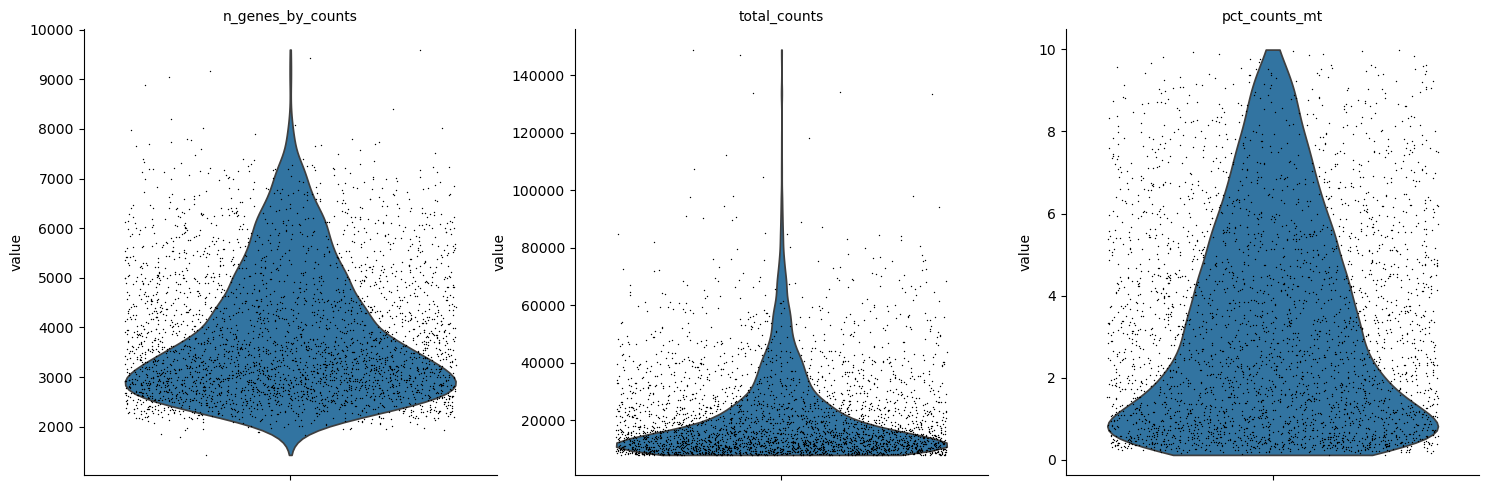

/tmp/ipykernel_6853/3899688235.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006647_BC4


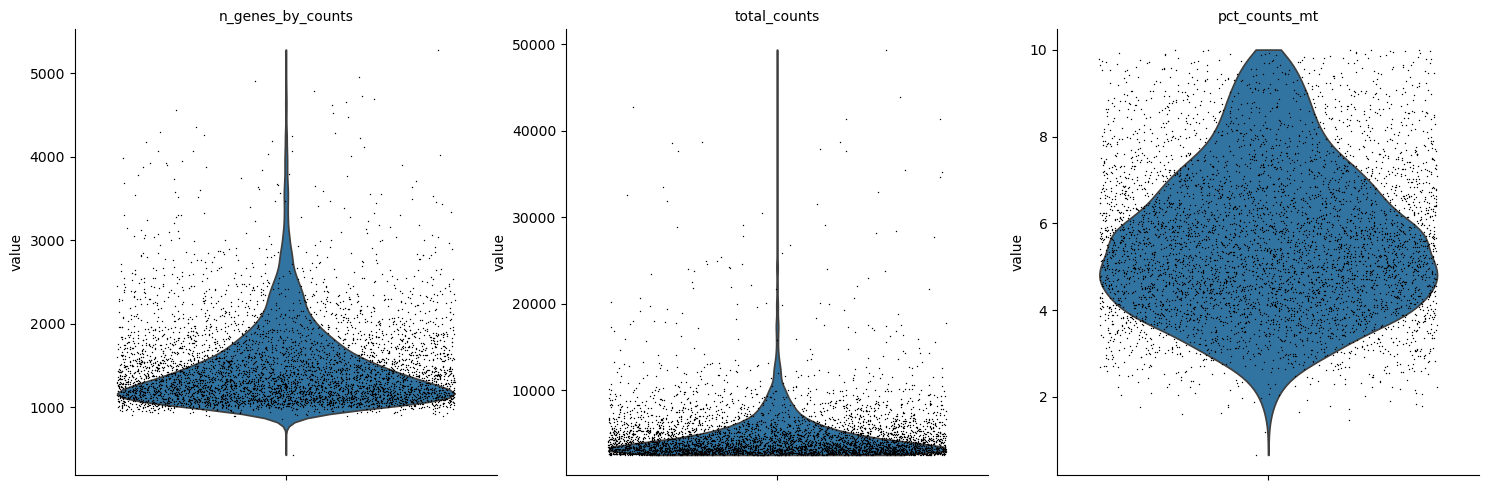

/tmp/ipykernel_6853/3899688235.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006648_BC5


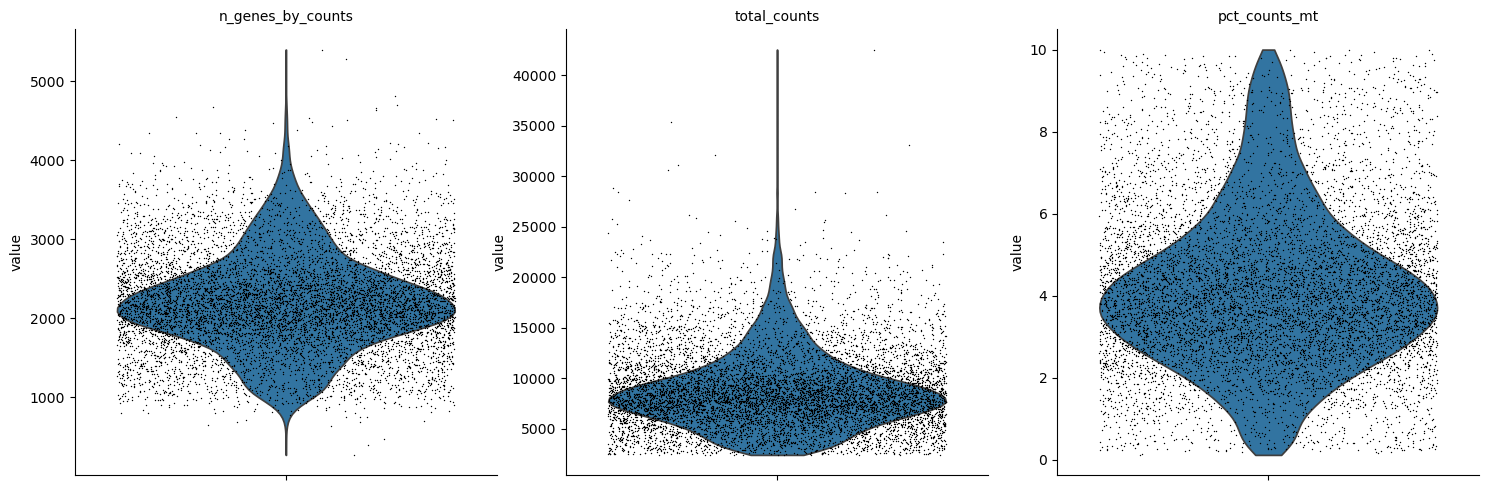

/tmp/ipykernel_6853/3899688235.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751267_BC6


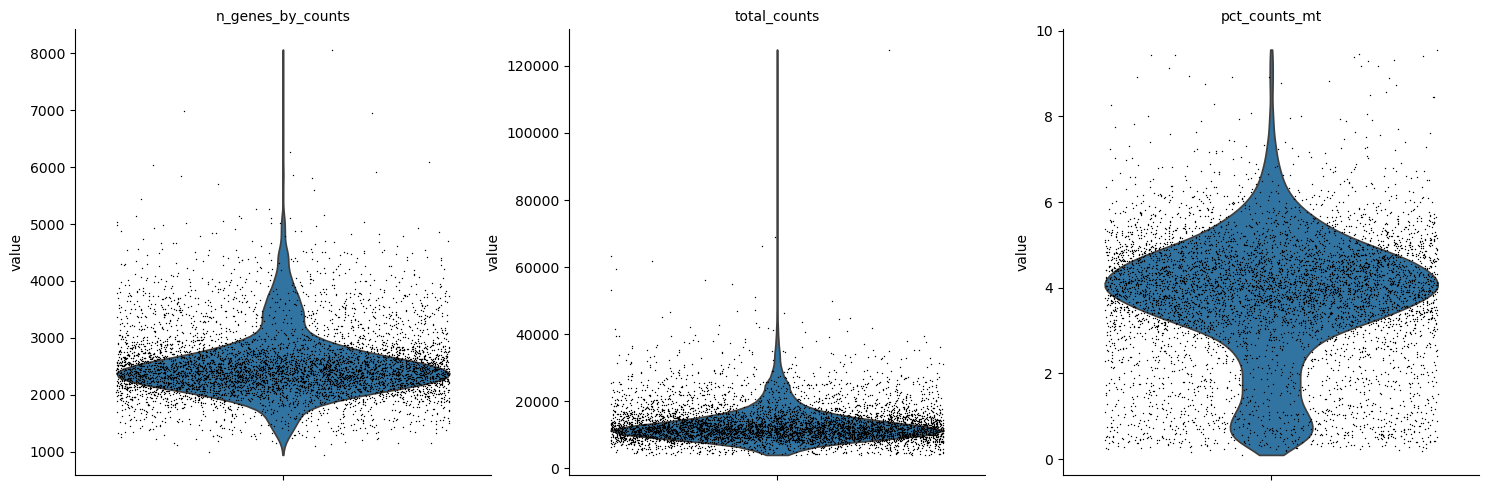

/tmp/ipykernel_6853/3899688235.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751268_BC7


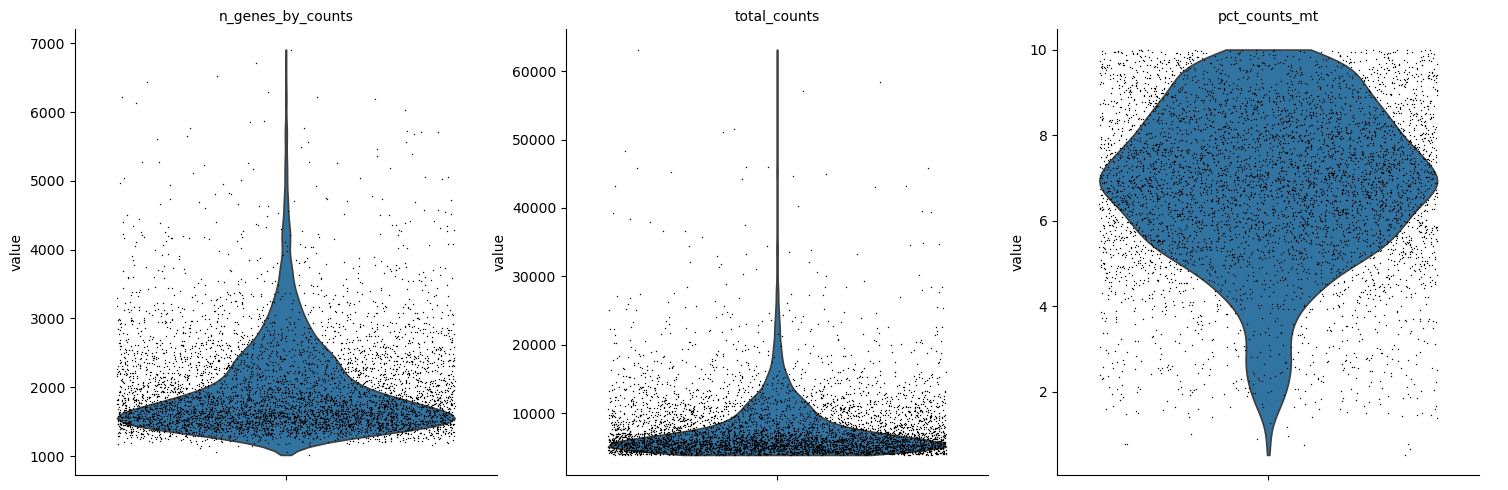

/tmp/ipykernel_6853/3899688235.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


In [4]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:
    file_path = f"{name}_gene_cell_exprs_table.txt.gz"
    df = pd.read_csv(file_path, sep='\t')
    df.index = df.iloc[:, 0]
    gene_symbols = df.iloc[:,:2]

    # Drop the first two columns (Ensembl ID and gene name)
    df = df.iloc[:, 2:]
    # Transpose so that cells are rows and genes are columns
    df = df.T

    adata = ad.AnnData(df)

    adata.obs['CellID']= df.index
    adata.var[['Ensemble_ID','Gene']]= gene_symbols
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print(name)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)
    
    adata= adata[adata.obs.n_genes_by_counts <6001, :]
    #adata= adata[adata.obs.pct_counts_mt< 5, :].copy()

    adata.obs['source'] = name
    adata.layers["counts"] = adata.X.copy()    

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata  # keep full dimension safe
    adata_list.append(adata)

In [5]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)       

/tmp/ipykernel_6853/1630503105.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


In [6]:
immune_remove = pd.read_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/immune_cells_obs.pkl')

In [7]:
adata_non_immune = adata[~adata.obs.index.isin(immune_remove.index),]

In [8]:
adata_non_immune

View of AnnData object with n_obs × n_vars = 27864 × 13656
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'Gene-GSM4751268_BC7', '

In [9]:
adata_non_immune.raw = adata_non_immune  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata_non_immune,
    flavor="seurat_v3",
    n_top_genes=4000,
    layer="counts",
    batch_key="source",
    subset=True,
)

In [10]:
adata_non_immune.var

,mt,Ensemble_ID-GSM4006644_BC1,Gene-GSM4006644_BC1,n_cells_by_counts-GSM4006644_BC1,mean_counts-GSM4006644_BC1,pct_dropout_by_counts-GSM4006644_BC1,total_counts-GSM4006644_BC1,Ensemble_ID-GSM4006647_BC4,Gene-GSM4006647_BC4,n_cells_by_counts-GSM4006647_BC4,...,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,False,ENSG00000000003,TSPAN6,2473,3.086700,23.151025,9933,ENSG00000000003,TSPAN6,1048,...,2339,0.638059,57.649828,3524,True,1960.0,0.752082,2.195721,1.075032,2
CFH,False,ENSG00000000971,CFH,166,0.059043,94.841516,190,ENSG00000000971,CFH,25,...,2167,0.568713,60.764077,3141,True,1777.0,0.357953,0.632659,1.051342,3
GCLC,False,ENSG00000001084,GCLC,2693,3.926041,16.314481,12634,ENSG00000001084,GCLC,228,...,1036,0.232301,81.242079,1283,True,1064.5,0.699361,3.074778,1.164049,4
STPG1,False,ENSG00000001460,STPG1,1468,0.857986,54.381603,2761,ENSG00000001460,STPG1,130,...,412,0.100127,92.540286,553,True,1111.0,0.161355,0.307524,1.282538,4
LAS1L,False,ENSG00000001497,LAS1L,534,0.213176,83.405842,686,ENSG00000001497,LAS1L,227,...,389,0.073873,92.956726,408,True,1541.0,0.091480,0.099624,0.978766,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP11-2C24.9,False,ENSG00000282034,RP11-2C24.9,249,0.085457,92.262275,275,ENSG00000282034,RP11-2C24.9,42,...,145,0.026797,97.374615,148,True,752.0,0.036570,0.039110,0.977658,1
ADORA3,False,ENSG00000282608,ADORA3,14,0.004972,99.564947,16,ENSG00000282608,ADORA3,12,...,31,0.007605,99.438711,42,True,741.0,0.002333,0.003476,1.267592,3
BISPR,False,ENSG00000282851,BISPR,448,0.153511,86.078310,494,ENSG00000282851,BISPR,14,...,203,0.038385,96.324461,212,True,607.0,0.076622,0.083100,0.983517,1


In [11]:
adata_non_immune.var[adata_non_immune.var['highly_variable']==True].index

Index(['TSPAN6', 'CFH', 'GCLC', 'STPG1', 'LAS1L', 'CD99', 'HS3ST1', 'MAD1L1',
       'TMEM176A', 'TFPI',
       ...
       'XX-FW83563B9.5', 'AL365181.2', 'AC133644.2', 'LINC00921', 'AC241585.2',
       'RP11-2C24.9', 'ADORA3', 'BISPR', 'RP1-34B20.21', 'RP11-297A16.4'],
      dtype='object', name='Gene', length=4000)

In [12]:
import scvi
scvi.model.SCVI.setup_anndata(adata_non_immune, layer="counts", batch_key="source")

In [13]:
model = scvi.model.SCVI(adata_non_immune, n_layers=2, n_latent=30, gene_likelihood="nb")

In [14]:
model.train()

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bo

Training:   0%|          | 0/287 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=287` reached.


In [15]:
SCVI_LATENT_KEY = "X_scVI"
adata_non_immune.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [16]:
sc.pp.neighbors(adata_non_immune, use_rep=SCVI_LATENT_KEY)


In [17]:
sc.tl.leiden(adata_non_immune,resolution=0.5,  random_state=0)

/tmp/ipykernel_6853/2299260946.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_non_immune,resolution=0.5,  random_state=0)


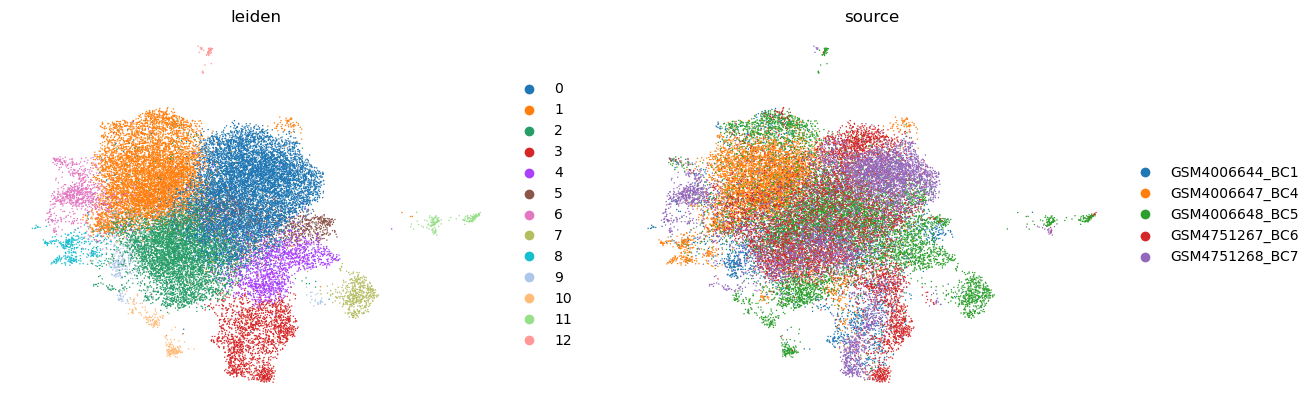

In [18]:
sc.tl.umap(adata_non_immune)#, min_dist=0.5)
sc.pl.umap(
    adata_non_immune,
    color=[ "leiden","source",],
    frameon=False,
    ncols=2
)

In [23]:
outdir = '/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_scvi/'
model_dir = os.path.join(outdir, "blca_scvi_4000_model")
model.save(model_dir, overwrite=True)

In [20]:
adata_non_immune

AnnData object with n_obs × n_vars = 27864 × 4000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM475126

In [21]:
###Breakdown of cells counts per cluster
pd.crosstab(adata_non_immune.obs['source'],adata_non_immune.obs['leiden'])

leiden,0,1,2,3,4,5,6,7,8,9,10,11,12
source,,,,,,,,,,,,,
GSM4006644_BC1,396,553,536,498,162,389,74,10,56,217,7,1,0
GSM4006647_BC4,50,4344,273,73,61,3,60,0,257,0,0,0,0
GSM4006648_BC5,2373,1295,1908,36,755,988,121,451,26,44,207,142,44
GSM4751267_BC6,2392,508,1823,677,505,52,56,0,2,18,2,10,1
GSM4751268_BC7,3230,203,715,502,139,6,553,1,16,16,0,20,7


In [24]:
adata_non_immune.write_h5ad(os.path.join(outdir,'scVI_blca_4000.h5ad'),compression='gzip')

In [32]:
obs= pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/non_immune_cells_obs.csv',index_col=0)
obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden,Stage
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,5,Ta
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,2,Ta
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,2,Ta
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,4,Ta
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,1,Ta
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,0,Ta
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,0,Ta
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,2,Ta
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,1,Ta


In [35]:
obs['leiden'].value_counts()

leiden
0     7129
1     5707
2     4849
3     3535
4     2870
5     1554
6      729
7      495
8      341
9      261
10     181
11      98
12      62
13      53
Name: count, dtype: int64

In [33]:
adata_non_immune.obs['leiden_target']= obs.loc[adata_non_immune.obs.index,'leiden']
adata_non_immune.obs['leiden_target'].value_counts()

In [36]:
change_per_cluster_de = model.differential_expression(groupby="leiden_target")

DE...:   0%|          | 0/14 [00:00<?, ?it/s]

In [37]:
change_per_cluster_de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Gene,,,,,,,,,,,,,,,,,,,,,
S100A8,0.9742,0.0258,3.631242,0.000068,0.002597,0.0,0.25,-4.940339,-4.793756,7.246999,...,0.261327,7.111502,0.049236,0.313865,0.756252,25.458166,True,0 vs Rest,0,Rest
UPK1B,0.9700,0.0300,3.476098,0.000042,0.000243,0.0,0.25,-3.101757,-3.286314,4.861059,...,0.287558,2.020304,0.109973,0.337449,0.419138,2.432340,True,0 vs Rest,0,Rest
S100A9,0.9686,0.0314,3.429044,0.000147,0.003291,0.0,0.25,-4.125431,-4.191549,5.131128,...,0.581568,10.245720,0.154720,0.522450,1.424234,32.710118,True,0 vs Rest,0,Rest
CDKN2A,0.9678,0.0322,3.403059,0.000034,0.000088,0.0,0.25,-0.604535,-1.137164,6.045901,...,0.201711,0.420786,0.116566,0.231396,0.326250,0.921689,True,0 vs Rest,0,Rest
MSMB,0.9678,0.0322,3.403059,0.000147,0.000030,0.0,0.25,1.431355,1.733050,4.346776,...,0.574835,0.162286,0.211390,0.088064,1.419446,0.286058,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARPC2,0.5548,0.4452,0.220084,0.001231,0.001329,0.0,0.25,-0.081851,-0.079145,0.447133,...,4.754717,8.273633,0.924528,0.969580,11.905718,13.336962,False,13 vs Rest,13,Rest
LMAN2,0.5436,0.4564,0.174844,0.000201,0.000205,0.0,0.25,0.046254,0.011744,0.531795,...,0.830189,1.136673,0.547170,0.613031,1.957186,2.065747,False,13 vs Rest,13,Rest
TRMT112,0.5368,0.4632,0.147467,0.000640,0.000635,0.0,0.25,0.025226,0.066375,0.409129,...,2.377358,3.520657,0.849057,0.894179,6.295366,6.085605,False,13 vs Rest,13,Rest


In [41]:
change_per_cluster_de[change_per_cluster_de['comparison']=='1 vs Rest'].to_csv(os.path.join(outdir,'Cluster1_4000.csv'))

### Cluster 1 vs the rest 

In [42]:
indices_t2 = pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/index_cluster1T2.csv', header=None)
indices_t2 = indices_t2.values.flatten()

In [43]:
indices_t2

array(['AAACCTGAGTCCAGGA.1-GSM4006647_BC4',
       'AAACCTGCAATTCCTT.1-GSM4006647_BC4',
       'AAACCTGGTGTGACGA.1-GSM4006647_BC4', ...,
       'TTTGTCATCACTGGGC.1-GSM4006647_BC4',
       'TTTGTCATCGCTTGTC.1-GSM4006647_BC4',
       'TTTGTCATCTGTACGA.1-GSM4006647_BC4'], dtype=object)

In [45]:
adata_non_immune.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden,leiden_target,_scvi_raw_norm_scaling
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,2,5,0.557320
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,4,2,1.432460
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,2,2,0.686248
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,3,4,1.076774
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,0,1,0.844737
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,0,0,2.565418
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,0,0,3.713331
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,2,2,0.779666
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,1,1,1.606426


In [47]:
adata_non_immune.obs.loc[indices_t2,'leiden_target'] = 'Cluster1_T2'

/tmp/ipykernel_6853/3627026530.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Cluster1_T2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata_non_immune.obs.loc[indices_t2,'leiden_target'] = 'Cluster1_T2'


In [50]:
change_per_cluster_de_t2 = model.differential_expression(groupby="leiden_target")

DE...:   0%|          | 0/15 [00:00<?, ?it/s]

In [53]:
change_per_cluster_de_t2[change_per_cluster_de_t2['comparison'] =='Cluster1_T2 vs Rest'].to_csv(os.path.join(outdir,'scvi_4000_cluster1t2.csv'))

### Dot products

In [54]:
wkdir= "/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_LINCS/"
data_year = "2020"
cell_name = "BC3C"

data_dir = os.path.join(wkdir,"00_outputs_" + data_year + "_" + cell_name)
data_file = os.path.join(data_dir, "Data_norm_" + data_year + "_" + cell_name+ ".xlsx")
Data_norm = pd.read_excel(data_file, index_col = 0)
display(Data_norm)

genes_list = Data_norm.columns.to_list()
print("Landmark genes in LINCS data:", len(genes_list), genes_list)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
ASG002_BC3C_24H:A03,-0.191254,-0.055246,0.039596,-0.256266,-0.040419,-0.590523,-0.159396,-0.074319,0.457981,0.409608,...,0.543203,0.494266,-0.011923,-0.225931,0.285054,-0.775246,0.166031,-0.024873,0.238723,0.284204
ASG002_BC3C_24H:A04,-0.265754,-0.317496,0.118696,-0.136665,-0.301569,-0.403023,0.124804,-0.036470,0.311931,0.660457,...,-0.565096,-0.088634,0.122977,-0.047931,0.141804,0.129054,-0.028819,-0.028773,-0.253627,-0.752646
ASG002_BC3C_24H:A05,-0.181954,-0.081597,-0.210304,1.559535,-0.019019,-0.457423,0.071404,0.074080,-0.356119,0.498808,...,0.226104,-0.228034,-0.121023,-0.075331,-0.133146,0.355054,0.022831,-0.084073,0.283123,-0.894896
ASG002_BC3C_24H:A06,0.033446,0.042404,-0.150154,-0.093165,0.053180,-0.053823,0.087704,0.167681,-0.601569,0.383308,...,-0.608596,-0.228835,0.072777,0.082970,-0.570996,2.847754,-0.211670,-0.067273,0.081723,0.338704
ASG002_BC3C_24H:J13,0.204446,0.180704,0.089096,-0.054666,0.053381,0.044877,-0.277396,-0.157419,0.535681,-3.933493,...,-0.318397,0.122265,-0.134323,-0.088931,-0.067996,-0.515847,-0.005069,0.067527,0.002223,0.204904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOAR012_BC3C_24H:P20,0.647151,0.211700,-0.979200,0.597350,-0.375751,0.388300,0.394524,0.120151,-0.166775,-1.129125,...,-1.598475,-0.552750,0.515151,0.120800,0.082675,0.529700,0.383225,-0.207225,2.268450,-1.248500
MOAR012_BC3C_24H:P21,0.171800,0.046300,-0.145550,-0.295150,0.030849,0.420951,0.222075,0.179800,0.274724,-0.423975,...,-1.650575,0.203600,-0.003250,-0.064800,-0.037675,0.076499,0.201825,0.416875,0.287450,-0.971700
MOAR012_BC3C_24H:P22,0.648700,0.058749,-0.031700,0.408249,-0.753950,0.332200,-0.357525,-0.107650,-0.213575,0.074225,...,0.127625,0.031600,0.103250,-0.249600,0.046375,1.486200,0.440325,0.090075,-0.031650,-0.944300
MOAR012_BC3C_24H:P23,0.090499,-0.469300,-0.611800,0.873550,-0.788450,-0.097199,-0.366575,-0.490600,-0.624675,-0.009275,...,0.054676,-0.596050,0.084600,0.444700,0.431375,-0.921501,0.044926,0.716076,-0.000900,-1.106700


Landmark genes in LINCS data: 978 ['AARS', 'ABCB6', 'ABCC5', 'ABCF1', 'ABCF3', 'ABHD4', 'ABHD6', 'ABL1', 'ACAA1', 'ACAT2', 'ACBD3', 'ACD', 'ACLY', 'ACOT9', 'ADAM10', 'ADAT1', 'ADGRE5', 'ADGRG1', 'ADH5', 'ADI1', 'ADO', 'ADRB2', 'AGL', 'AKAP8', 'AKAP8L', 'AKR7A2', 'AKT1', 'ALAS1', 'ALDH7A1', 'ALDOA', 'ALDOC', 'AMDHD2', 'ANKRD10', 'ANO10', 'ANXA7', 'APBB2', 'APOE', 'APP', 'APPBP2', 'ARFIP2', 'ARHGAP1', 'ARHGEF12', 'ARHGEF2', 'ARID4B', 'ARID5B', 'ARL4C', 'ARNT2', 'ARPP19', 'ASAH1', 'ASCC3', 'ATF1', 'ATF5', 'ATF6', 'ATG3', 'ATMIN', 'ATP11B', 'ATP1B1', 'ATP2C1', 'ATP6V0B', 'ATP6V1D', 'AURKA', 'AURKB', 'AXIN1', 'B4GAT1', 'BACE2', 'BAD', 'BAG3', 'BAMBI', 'BAX', 'BCL2', 'BCL7B', 'BDH1', 'BECN1', 'BHLHE40', 'BID', 'BIRC2', 'BIRC5', 'BLCAP', 'BLMH', 'BLVRA', 'BMP4', 'BNIP3', 'BNIP3L', 'BPHL', 'BRCA1', 'BTK', 'BUB1B', 'BZW2', 'C2CD2', 'C2CD2L', 'C2CD5', 'C5', 'CAB39', 'CALM3', 'CALU', 'CAMSAP2', 'CANT1', 'CAPN1', 'CARMIL1', 'CASC3', 'CASK', 'CASP10', 'CASP2', 'CASP3', 'CASP7', 'CAST', 'CAT', 'CBLB

In [56]:
#Depmap
import re
blca= pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_depmep/OmicsExpressionProteinCodingGenesTPMLogp1.csv',index_col=0)

blca.columns = [re.sub(r'\s*\(.*?\)', '', s) for s in list(blca.columns)]
blca

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,H3C2,H3C3,AC098582.1,DUS4L-BCAP29,C8orf44-SGK3,ELOA3B,NPBWR1,ELOA3D,ELOA3,CDR1
ACH-001113,4.331992,0.000000,7.364660,2.792855,4.471187,0.028569,1.226509,3.044394,6.500005,4.739848,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.000000,0.275007,0.0,0.000000,0.000000
ACH-001289,4.567424,0.584963,7.106641,2.543496,3.504620,0.000000,0.189034,3.813525,4.221877,3.481557,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.000000,0.014355,0.0,0.000000,0.000000
ACH-001339,3.150560,0.000000,7.379118,2.333424,4.228049,0.056584,1.310340,6.687201,3.682573,3.273516,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.000000,0.084064,0.0,0.000000,0.042644
ACH-001538,5.085340,0.000000,7.154211,2.545968,3.084064,0.000000,5.868390,6.165309,4.489928,3.956986,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.000000,0.028569,0.0,0.000000,0.000000
ACH-000242,6.729417,0.000000,6.537917,2.456806,3.867896,0.799087,7.208478,5.570159,7.127117,4.568032,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.000000,0.464668,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000285,0.056584,0.000000,6.604368,3.266037,4.973152,0.411426,0.097611,0.704872,4.829850,5.178715,...,2.229588,0.084064,1.310340,3.039138,0.344828,0.000000,0.000000,0.0,0.475085,0.042644
ACH-002669,3.111031,0.000000,7.031329,1.541019,3.664483,0.014355,3.624101,6.805421,4.472488,4.397118,...,0.189034,0.400538,0.356144,1.327687,0.000000,0.000000,0.014355,0.0,0.000000,0.000000
ACH-001858,4.390943,0.000000,7.013239,1.887525,3.252476,0.028569,3.286881,6.902194,5.410748,3.401903,...,1.097611,0.400538,0.613532,1.992768,0.704872,0.000000,1.464668,0.0,0.000000,0.526069
ACH-001997,5.057450,0.000000,7.815191,2.538538,3.893362,0.028569,4.079805,6.971659,4.469886,3.463361,...,0.831877,0.847997,1.292782,2.153805,0.687061,0.000000,0.000000,0.0,0.000000,0.000000


In [57]:
def compute_invasiveness_score(blca, vector, vector_name='n', score_name='invasiveness'):
    """
    Compute invasiveness score via dot product between expression and gene vector.

    Parameters:
        blca (pd.DataFrame): Gene expression DataFrame (samples as rows, genes as columns).
        vector (pd.DataFrame or pd.Series): Gene weights with gene names as index.
        vector_name (str): Column name to extract from DataFrame if `vector` is a DataFrame.
        score_name (str): Name for the output score column.

    Returns:
        pd.DataFrame: DataFrame with index as blca samples and one column: score_name.
    """
    # Align vector and expression matrix by intersecting genes
    common_genes = blca.columns.intersection(vector.index)
    common_genes = common_genes.intersection(genes_list)
    print(len(common_genes))
    print(common_genes)
    vector_aligned = vector.loc[common_genes]
    print(vector_aligned)
    if isinstance(vector_aligned, pd.DataFrame):
        vector_aligned = vector_aligned[vector_name]

    blca_aligned = blca[common_genes]
    print(blca_aligned)
    # Compute dot product
    scores = blca_aligned.dot(vector_aligned)

    # Wrap in DataFrame
    score_df = pd.DataFrame(scores, columns=[score_name])
    
    return score_df


In [67]:
DPD_df = compute_invasiveness_score(blca, change_per_cluster_de[change_per_cluster_de['comparison'] == '1 vs Rest'], vector_name='lfc_mean', score_name='invasiveness')
display(DPD_df)

330
Index(['TSPAN6', 'RALA', 'FYN', 'BRCA1', 'MVP', 'HEBP1', 'BID', 'ZDHHC6',
       'RNH1', 'TOMM34',
       ...
       'PSMB10', 'RNPS1', 'MLLT11', 'CSNK1E', 'TSPAN4', 'FASTKD5', 'CEBPD',
       'PRAF2', 'HOXA10', 'LYN'],
      dtype='object', length=330)
         proba_de  proba_not_de  bayes_factor        scale1    scale2  \
TSPAN6     0.6998        0.3002      0.846346  1.156535e-04  0.000128   
RALA       0.8390        0.1610      1.650806  6.098667e-05  0.000068   
FYN        0.9198        0.0802      2.439633  8.184097e-07  0.000002   
BRCA1      0.9056        0.0944      2.261057  5.211824e-06  0.000006   
MVP        0.7748        0.2252      1.235616  4.701815e-05  0.000052   
...           ...           ...           ...           ...       ...   
FASTKD5    0.8232        0.1768      1.538180  6.501184e-06  0.000009   
CEBPD      0.8398        0.1602      1.656741  3.440911e-04  0.000434   
PRAF2      0.8794        0.1206      1.986761  2.329413e-05  0.000036   
HOXA10     0

,invasiveness
ACH-001113,255.448107
ACH-001289,286.724653
ACH-001339,289.660690
ACH-001538,291.185442
ACH-000242,199.910969
...,...
ACH-000285,317.619483
ACH-002669,249.926694
ACH-001858,250.101284
ACH-001997,250.577731


In [68]:
cell_line_ids=['ACH-000142','ACH-000593','ACH-000396','ACH-000242','ACH-000384',
               'ACH-000018','ACH-000724']

DPD_cell_lines= DPD_df.loc[cell_line_ids]
DPD_cell_lines['cell_line_name']=['CAL29','BC3C','J82','RT4','SW780','T24','HT1376']
DPD_cell_lines

,invasiveness,cell_line_name
ACH-000142,216.319790,CAL29
ACH-000593,239.852885,BC3C
ACH-000396,228.044145,J82
ACH-000242,199.910969,RT4
ACH-000384,244.964063,SW780
ACH-000018,259.213107,T24
ACH-000724,294.127816,HT1376


In [80]:
change_per_cluster_de_t2[(change_per_cluster_de_t2['comparison'] == 'Cluster1_T2 vs Rest')&(change_per_cluster_de_t2['is_de_fdr_0.05'] == True)]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Gene,,,,,,,,,,,,,,,,,,,,,
KRTDAP,0.9904,0.0096,4.636345,1.645426e-04,0.000008,0.0,0.25,7.108581,7.356842,2.963275,...,0.551532,0.041253,0.175139,0.018046,2.001132,0.085544,True,Cluster1_T2 vs Rest,Cluster1_T2,Rest
IGFBP2,0.9890,0.0110,4.498798,5.395619e-07,0.000868,0.0,0.25,-9.502110,-10.443290,3.329236,...,0.001741,5.539653,0.001741,0.724032,0.009924,8.129814,True,Cluster1_T2 vs Rest,Cluster1_T2,Rest
LYNX1,0.9886,0.0114,4.462676,3.278028e-04,0.000024,0.0,0.25,7.492585,7.972758,2.794628,...,0.794916,0.097591,0.384401,0.048015,3.599149,0.269223,True,Cluster1_T2 vs Rest,Cluster1_T2,Rest
SPOCD1,0.9882,0.0118,4.427785,8.351483e-07,0.000201,0.0,0.25,-7.106147,-7.605971,2.646371,...,0.000348,1.419374,0.000348,0.483395,0.001912,1.972708,True,Cluster1_T2 vs Rest,Cluster1_T2,Rest
SERPINB4,0.9878,0.0122,4.394043,2.668093e-04,0.000022,0.0,0.25,7.720734,7.901771,3.800626,...,0.667827,0.099672,0.388928,0.049656,2.905878,0.233972,True,Cluster1_T2 vs Rest,Cluster1_T2,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZC3H8,0.9170,0.0830,2.402267,5.183849e-05,0.000026,0.0,0.25,1.173357,1.225840,0.814151,...,0.105501,0.147167,0.098886,0.129201,0.503998,0.251882,True,Cluster1_T2 vs Rest,Cluster1_T2,Rest
LGALS3,0.9170,0.0830,2.402267,2.264711e-04,0.000466,0.0,0.25,-0.604855,-0.888923,1.339130,...,0.496170,2.748440,0.355850,0.746719,2.202858,4.734367,True,Cluster1_T2 vs Rest,Cluster1_T2,Rest
TCEA3,0.9170,0.0830,2.402267,1.558823e-04,0.000061,0.0,0.25,1.904158,1.724320,1.491865,...,0.319290,0.296735,0.268454,0.229633,1.511316,0.592967,True,Cluster1_T2 vs Rest,Cluster1_T2,Rest


In [81]:
DPD_df = compute_invasiveness_score(blca, change_per_cluster_de_t2[(change_per_cluster_de_t2['comparison'] == 'Cluster1_T2 vs Rest')&(change_per_cluster_de_t2['is_de_fdr_0.05'] == True)], vector_name='lfc_mean', score_name='invasiveness')
display(DPD_df)

107
Index(['FYN', 'BRCA1', 'HEBP1', 'ZDHHC6', 'SPAG4', 'MYLK', 'MTHFD2', 'CDC42',
       'PTGS2', 'EDN1',
       ...
       'INSIG1', 'S100A4', 'PDGFA', 'HSD17B11', 'CTNND1', 'HLA-DRA', 'HSPA1A',
       'TSPAN4', 'HOXA10', 'LYN'],
      dtype='object', length=107)
         proba_de  proba_not_de  bayes_factor    scale1    scale2  \
FYN        0.9342        0.0658      2.653071  0.000001  0.000002   
BRCA1      0.9180        0.0820      2.415478  0.000007  0.000005   
HEBP1      0.9748        0.0252      3.655388  0.000018  0.000112   
ZDHHC6     0.9576        0.0424      3.117282  0.000016  0.000043   
SPAG4      0.9172        0.0828      2.404897  0.000030  0.000066   
...           ...           ...           ...       ...       ...   
HLA-DRA    0.9380        0.0620      2.716615  0.000128  0.000250   
HSPA1A     0.9564        0.0436      3.088119  0.001016  0.000510   
TSPAN4     0.9206        0.0794      2.450527  0.000009  0.000007   
HOXA10     0.9218        0.0782      2.467059

,invasiveness
ACH-001113,368.708863
ACH-001289,474.677971
ACH-001339,420.837196
ACH-001538,435.803995
ACH-000242,238.613170
...,...
ACH-000285,572.402824
ACH-002669,368.374128
ACH-001858,357.627583
ACH-001997,401.261155


In [82]:
cell_line_ids=['ACH-000142','ACH-000593','ACH-000396','ACH-000242','ACH-000384',
               'ACH-000018','ACH-000724']

DPD_cell_lines= DPD_df.loc[cell_line_ids]
DPD_cell_lines['cell_line_name']=['CAL29','BC3C','J82','RT4','SW780','T24','HT1376']
DPD_cell_lines

,invasiveness,cell_line_name
ACH-000142,255.611432,CAL29
ACH-000593,344.377485,BC3C
ACH-000396,303.063883,J82
ACH-000242,238.613170,RT4
ACH-000384,344.563608,SW780
ACH-000018,356.688574,T24
ACH-000724,441.884464,HT1376


### Current classification

In [77]:
pd.crosstab(adata_non_immune.obs['leiden'],adata_non_immune.obs['source'])

source,GSM4006644_BC1,GSM4006647_BC4,GSM4006648_BC5,GSM4751267_BC6,GSM4751268_BC7
leiden,,,,,
0,396,50,2373,2392,3230
1,553,4344,1295,508,203
2,536,273,1908,1823,715
3,498,73,36,677,502
4,162,61,755,505,139
5,389,3,988,52,6
6,74,60,121,56,553
7,10,0,451,0,1
8,56,257,26,2,16


In [83]:
change_per_cluster_de_current= model.differential_expression(groupby="leiden")

DE...:   0%|          | 0/13 [00:00<?, ?it/s]

In [85]:
change_per_cluster_de_current[change_per_cluster_de_current['comparison'] == '1 vs Rest']

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Gene,,,,,,,,,,,,,,,,,,,,,
S100A8,0.9842,0.0158,4.131819,0.006776,0.000349,0.0,0.25,7.952199,8.713253,7.348020,...,16.302622,1.754830,0.669419,0.106770,66.966740,3.387003,True,1 vs Rest,1,Rest
TOP2A,0.9830,0.0170,4.057395,0.000086,0.000007,0.0,0.25,4.500432,4.837104,3.379375,...,0.450529,0.035733,0.191511,0.023472,0.891866,0.052736,True,1 vs Rest,1,Rest
UBE2C,0.9810,0.0190,3.944133,0.000230,0.000018,0.0,0.25,5.212554,5.297138,4.359634,...,1.222802,0.114498,0.319281,0.052240,2.404946,0.169227,True,1 vs Rest,1,Rest
RRM2,0.9802,0.0198,3.902074,0.000086,0.000005,0.0,0.25,5.068994,5.567833,3.661119,...,0.415182,0.030008,0.188759,0.019131,0.871309,0.046433,True,1 vs Rest,1,Rest
S100A9,0.9796,0.0204,3.871609,0.007984,0.000670,0.0,0.25,5.490993,5.985564,5.337909,...,19.486890,3.915510,0.787339,0.310147,78.763504,6.902972,True,1 vs Rest,1,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDUFB4,0.5400,0.4600,0.160343,0.000525,0.000542,0.0,0.25,-0.027184,-0.022252,0.479405,...,2.324352,3.240542,0.753730,0.905109,5.113602,5.200892,False,1 vs Rest,1,Rest
PTRHD1,0.4842,0.5158,-0.063221,0.000244,0.000257,0.0,0.25,-0.060719,-0.086794,0.401711,...,1.034623,1.576070,0.539765,0.698583,2.275679,2.388006,False,1 vs Rest,1,Rest
TOMM20,0.4752,0.5248,-0.099281,0.000267,0.000270,0.0,0.25,-0.000133,-0.000404,0.421692,...,1.247574,1.843901,0.575547,0.737560,2.674006,2.734097,False,1 vs Rest,1,Rest


In [89]:
DPD_df = compute_invasiveness_score(blca, change_per_cluster_de_current[(change_per_cluster_de_current['comparison'] == '1 vs Rest')&(change_per_cluster_de_current['is_de_fdr_0.05'] == True)], 
                                    vector_name='lfc_mean', score_name='invasiveness')
display(DPD_df)

330
Index(['TSPAN6', 'RALA', 'FYN', 'BRCA1', 'MVP', 'HEBP1', 'BID', 'ZDHHC6',
       'RNH1', 'TOMM34',
       ...
       'PSMB10', 'RNPS1', 'MLLT11', 'CSNK1E', 'TSPAN4', 'FASTKD5', 'CEBPD',
       'PRAF2', 'HOXA10', 'LYN'],
      dtype='object', length=330)
         proba_de  proba_not_de  bayes_factor        scale1    scale2  \
TSPAN6     0.6944        0.3056      0.820771  1.058201e-04  0.000132   
RALA       0.8606        0.1394      1.820282  6.939792e-05  0.000068   
FYN        0.9234        0.0766      2.489465  8.069661e-07  0.000002   
BRCA1      0.9306        0.0694      2.595943  1.253505e-05  0.000003   
MVP        0.7856        0.2144      1.298604  3.933950e-05  0.000055   
...           ...           ...           ...           ...       ...   
FASTKD5    0.8248        0.1752      1.549213  6.250938e-06  0.000009   
CEBPD      0.8470        0.1530      1.711263  3.278826e-04  0.000454   
PRAF2      0.8898        0.1102      2.088700  2.320450e-05  0.000037   
HOXA10     0

,invasiveness
ACH-001113,643.736567
ACH-001289,710.415528
ACH-001339,684.337970
ACH-001538,676.094613
ACH-000242,547.885520
...,...
ACH-000285,789.666562
ACH-002669,614.840276
ACH-001858,613.108480
ACH-001997,600.595513


In [90]:
cell_line_ids=['ACH-000142','ACH-000593','ACH-000396','ACH-000242','ACH-000384',
               'ACH-000018','ACH-000724']

DPD_cell_lines= DPD_df.loc[cell_line_ids]
DPD_cell_lines['cell_line_name']=['CAL29','BC3C','J82','RT4','SW780','T24','HT1376']
DPD_cell_lines

,invasiveness,cell_line_name
ACH-000142,579.287605,CAL29
ACH-000593,638.412473,BC3C
ACH-000396,623.131937,J82
ACH-000242,547.885520,RT4
ACH-000384,612.118472,SW780
ACH-000018,685.179739,T24
ACH-000724,694.619110,HT1376


In [ ]:
change_per_cluster_de_current

### T2 vs the rest 

In [97]:
adata_non_immune.obs['Type']= 'Luminal'

In [102]:
adata_non_immune.obs['source'].value_counts()

source
GSM4006648_BC5    8390
GSM4751267_BC6    6046
GSM4751268_BC7    5408
GSM4006647_BC4    5121
GSM4006644_BC1    2899
Name: count, dtype: int64

In [103]:
adata_non_immune.obs.loc[adata_non_immune.obs['source']=='GSM4006647_BC4','Type'] = 'Basal'

In [104]:
adata_non_immune.obs['current_anno'] = adata_non_immune.obs['Type'].astype(str)+ '_' + adata_non_immune.obs['leiden'].astype(str)

In [105]:
adata_non_immune.obs['current_anno'].value_counts()

current_anno
Luminal_0     8391
Luminal_2     4982
Basal_1       4344
Luminal_1     2559
Luminal_3     1713
Luminal_4     1561
Luminal_5     1435
Luminal_6      804
Luminal_7      462
Luminal_9      295
Basal_2        273
Basal_8        257
Luminal_10     216
Luminal_11     173
Luminal_8      100
Basal_3         73
Basal_4         61
Basal_6         60
Luminal_12      52
Basal_0         50
Basal_5          3
Name: count, dtype: int64

### 

In [115]:
DPD_df = compute_invasiveness_score(blca, de_change[de_change['is_de_fdr_0.05'] == True], 
                                    vector_name='lfc_mean', score_name='invasiveness')
display(DPD_df)

164
Index(['RALA', 'FYN', 'BRCA1', 'HEBP1', 'ZDHHC6', 'TOMM34', 'CD44', 'TIMP2',
       'RFC2', 'LAMA3',
       ...
       'HSD17B11', 'DDX42', 'CTNND1', 'HLA-DRA', 'HSPA1A', 'TRIM13', 'PSMB10',
       'PRAF2', 'HOXA10', 'LYN'],
      dtype='object', length=164)
        proba_de  proba_not_de  bayes_factor    scale1        scale2  \
RALA      0.9012        0.0988      2.210630  0.000055  9.307107e-05   
FYN       0.9544        0.0456      3.041175  0.000001  4.047324e-07   
BRCA1     0.9298        0.0702      2.583621  0.000009  1.783772e-05   
HEBP1     0.9998        0.0002      8.516943  0.000019  1.279288e-04   
ZDHHC6    0.9952        0.0048      5.334326  0.000017  6.024362e-05   
...          ...           ...           ...       ...           ...   
TRIM13    0.9122        0.0878      2.340798  0.000063  3.085441e-05   
PSMB10    0.9546        0.0454      3.045780  0.000057  2.133968e-05   
PRAF2     0.9696        0.0304      3.462441  0.000011  4.306563e-05   
HOXA10    0.9562 

,invasiveness
ACH-001113,38.835472
ACH-001289,134.496749
ACH-001339,54.380165
ACH-001538,95.070294
ACH-000242,-114.255427
...,...
ACH-000285,248.477210
ACH-002669,33.436845
ACH-001858,21.155503
ACH-001997,81.785999


In [116]:
cell_line_ids=['ACH-000142','ACH-000593','ACH-000396','ACH-000242','ACH-000384',
               'ACH-000018','ACH-000724']

DPD_cell_lines= DPD_df.loc[cell_line_ids]
DPD_cell_lines['cell_line_name']=['CAL29','BC3C','J82','RT4','SW780','T24','HT1376']
DPD_cell_lines

,invasiveness,cell_line_name
ACH-000142,-109.847519,CAL29
ACH-000593,-26.712653,BC3C
ACH-000396,-46.430203,J82
ACH-000242,-114.255427,RT4
ACH-000384,-11.287377,SW780
ACH-000018,-1.565202,T24
ACH-000724,118.157174,HT1376


In [107]:
cell_type_1 = "Basal_1"
cell_idx1 = adata_non_immune.obs["current_anno"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "Luminal_1"
cell_idx2 = adata_non_immune.obs["current_anno"] == cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

4344 cells of type Basal_1
2559 cells of type Luminal_1


In [108]:
de_change = model.differential_expression(idx1=cell_idx1, idx2=cell_idx2)
de_change

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
Gene,,,,,,,,,,,,,,,,,,,
RP11-297A16.4,1.0000,0.0000,18.420681,3.923217e-05,4.792725e-06,0.0,0.25,3.176300,3.173545,0.779756,0.271544,6.693808,0.099217,0.034388,0.092081,0.032435,0.406273,0.046974,True
ADIRF,1.0000,0.0000,18.420681,9.196178e-04,1.358379e-02,0.0,0.25,-3.668220,-3.592062,1.145992,-8.142784,-0.251794,2.151934,118.221962,0.755064,1.000000,8.970971,135.325227,True
SPOCD1,1.0000,0.0000,18.420681,7.924631e-07,2.849334e-04,0.0,0.25,-8.288857,-8.217474,1.395019,-13.244411,-3.832576,0.001611,2.361469,0.001611,0.633841,0.007091,2.836977,True
TNFRSF18,1.0000,0.0000,18.420681,2.457942e-05,9.054475e-07,0.0,0.25,5.061986,5.126080,1.257074,0.672281,9.658228,0.051335,0.007034,0.049033,0.006643,0.224318,0.009714,True
DSC2,1.0000,0.0000,18.420681,1.033478e-04,8.896472e-07,0.0,0.25,7.550063,7.653656,1.369152,2.019989,11.529466,0.247698,0.005471,0.208103,0.005471,1.021554,0.009154,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STK16,0.5116,0.4884,0.046408,4.650106e-05,4.545770e-05,0.0,0.25,0.063102,0.071468,0.370491,-1.284625,1.455162,0.103591,0.355217,0.096455,0.289566,0.428910,0.437554,False
RPL38,0.4852,0.5148,-0.059217,2.223400e-03,2.336043e-03,0.0,0.25,-0.046325,-0.015128,0.348010,-1.115146,1.175009,5.395488,18.013677,0.984576,0.998828,22.397533,22.602815,False
SMDT1,0.4582,0.5418,-0.167591,3.458548e-04,3.665328e-04,0.0,0.25,-0.073274,-0.056069,0.349116,-1.399129,1.181299,0.891344,3.090270,0.554098,0.877296,3.586911,3.899386,False


In [114]:
de_change[de_change['is_de_fdr_0.05'] == True]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
Gene,,,,,,,,,,,,,,,,,,,
RP11-297A16.4,1.0000,0.0000,18.420681,3.923217e-05,4.792725e-06,0.0,0.25,3.176300,3.173545,0.779756,0.271544,6.693808,0.099217,0.034388,0.092081,0.032435,0.406273,0.046974,True
ADIRF,1.0000,0.0000,18.420681,9.196178e-04,1.358379e-02,0.0,0.25,-3.668220,-3.592062,1.145992,-8.142784,-0.251794,2.151934,118.221962,0.755064,1.000000,8.970971,135.325227,True
SPOCD1,1.0000,0.0000,18.420681,7.924631e-07,2.849334e-04,0.0,0.25,-8.288857,-8.217474,1.395019,-13.244411,-3.832576,0.001611,2.361469,0.001611,0.633841,0.007091,2.836977,True
TNFRSF18,1.0000,0.0000,18.420681,2.457942e-05,9.054475e-07,0.0,0.25,5.061986,5.126080,1.257074,0.672281,9.658228,0.051335,0.007034,0.049033,0.006643,0.224318,0.009714,True
DSC2,1.0000,0.0000,18.420681,1.033478e-04,8.896472e-07,0.0,0.25,7.550063,7.653656,1.369152,2.019989,11.529466,0.247698,0.005471,0.208103,0.005471,1.021554,0.009154,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FDPS,0.8934,0.1066,2.125951,3.783154e-04,5.690351e-04,0.0,0.25,-0.096349,-0.442261,1.373575,-4.045980,3.869349,0.870856,4.662368,0.532689,0.774912,3.547693,5.829044,True
HIST1H2BE,0.8934,0.1066,2.125951,2.603577e-06,1.683005e-06,0.0,0.25,1.003518,1.054664,1.175118,-3.235786,4.673346,0.005525,0.012114,0.005525,0.011723,0.023800,0.012531,True
MT-ND3,0.8934,0.1066,2.125951,5.382279e-03,3.462628e-03,0.0,0.25,0.942209,0.954439,1.161760,-2.723732,5.325993,11.867864,25.996874,0.998619,0.993748,51.812574,35.681340,True


In [109]:
de_change_uniform = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform["log10_pscore"] = np.log10(de_change_uniform["proba_not_de"])
de_change_uniform = de_change_uniform.join(adata.var, how="inner")
de_change_uniform.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751267_BC6,mean_counts-GSM4751267_BC6,pct_dropout_by_counts-GSM4751267_BC6,total_counts-GSM4751267_BC6,Ensemble_ID-GSM4751268_BC7,Gene-GSM4751268_BC7,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7
Gene,,,,,,,,,,,,,,,,,,,,,
TK1,0.9268,0.0732,2.538542,0.000025,0.000094,0.0,0.25,-0.891618,-0.643159,2.562754,...,52,0.018161,99.156802,112,ENSG00000167900,TK1,35,0.006518,99.366286,36
RRM2,0.9242,0.0758,2.500830,0.000023,0.000091,0.0,0.25,-1.045739,-0.721730,2.787767,...,29,0.010864,99.529755,67,ENSG00000171848,RRM2,10,0.003621,99.818939,20
CDKN3,0.9204,0.0796,2.447794,0.000017,0.000058,0.0,0.25,-0.906713,-0.623157,2.611911,...,42,0.011026,99.318956,68,ENSG00000100526,CDKN3,9,0.002173,99.837045,12
TOP2A,0.9192,0.0808,2.431527,0.000025,0.000093,0.0,0.25,-1.097603,-0.749685,2.720244,...,49,0.019621,99.205448,121,ENSG00000131747,TOP2A,9,0.003983,99.837045,22
CENPK,0.9160,0.0840,2.389199,0.000009,0.000024,0.0,0.25,-0.681222,-0.544656,2.232105,...,71,0.014594,98.848711,90,ENSG00000123219,CENPK,27,0.005251,99.511135,29


In [111]:
de_change_uniform

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751267_BC6,mean_counts-GSM4751267_BC6,pct_dropout_by_counts-GSM4751267_BC6,total_counts-GSM4751267_BC6,Ensemble_ID-GSM4751268_BC7,Gene-GSM4751268_BC7,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7
Gene,,,,,,,,,,,,,,,,,,,,,
TK1,0.9268,0.0732,2.538542,0.000025,0.000094,0.0,0.25,-0.891618,-0.643159,2.562754,...,52,0.018161,99.156802,112,ENSG00000167900,TK1,35,0.006518,99.366286,36
RRM2,0.9242,0.0758,2.500830,0.000023,0.000091,0.0,0.25,-1.045739,-0.721730,2.787767,...,29,0.010864,99.529755,67,ENSG00000171848,RRM2,10,0.003621,99.818939,20
CDKN3,0.9204,0.0796,2.447794,0.000017,0.000058,0.0,0.25,-0.906713,-0.623157,2.611911,...,42,0.011026,99.318956,68,ENSG00000100526,CDKN3,9,0.002173,99.837045,12
TOP2A,0.9192,0.0808,2.431527,0.000025,0.000093,0.0,0.25,-1.097603,-0.749685,2.720244,...,49,0.019621,99.205448,121,ENSG00000131747,TOP2A,9,0.003983,99.837045,22
CENPK,0.9160,0.0840,2.389199,0.000009,0.000024,0.0,0.25,-0.681222,-0.544656,2.232105,...,71,0.014594,98.848711,90,ENSG00000123219,CENPK,27,0.005251,99.511135,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OAZ1,0.2946,0.7054,-0.873146,0.001727,0.001759,0.0,0.25,-0.025624,-0.022152,0.240774,...,6158,9.926707,0.145938,61218,ENSG00000104904,OAZ1,5466,6.999457,1.032048,38658
RPS11,0.2778,0.7222,-0.955401,0.002790,0.002756,0.0,0.25,0.024430,0.014043,0.253435,...,6167,31.838171,0.000000,196346,ENSG00000142534,RPS11,5522,13.109723,0.018106,72405
TOMM7,0.2666,0.7334,-1.011942,0.001160,0.001150,0.0,0.25,0.015416,0.015316,0.236838,...,6126,6.820334,0.664829,42061,ENSG00000196683,TOMM7,5384,5.037661,2.516748,27823


In [110]:
de_change_importance = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="importance",
    filter_outlier_cells=True,
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_importance["log10_pscore"] = np.log10(de_change_importance["proba_not_de"])
de_change_importance = de_change_importance.join(adata.var, how="inner")

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
de_comp = pd.concat(
    [
        de_change_importance.assign(flavor="importance"),
        de_change_uniform.assign(flavor="uniform"),
    ]
)
de_comp["gene_type"] = "Other"
de_comp.loc[lambda x: x["gene_name"].str.contains("rpl-"), "gene_type"] = "RPL"
de_comp.loc[lambda x: x["gene_name"].str.contains("ceh-"), "gene_type"] = "CEH"
de_comp.loc[lambda x: x["gene_name"].str.contains("flp-"), "gene_type"] = "FPL"

(
    p9.ggplot(de_comp, p9.aes("lfc_mean", "-log10_pscore", color="gene_type"))
    + p9.geom_point(
        de_comp.query("gene_type == 'Other'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.geom_point(de_comp.query("gene_type != 'Other'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    + p9.facet_wrap("flavor")
)

In [ ]:
indices_ta = pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/index_cluster1Ta.csv', header=None)
indices_ta = indices_ta.values.flatten()

In [ ]:
adata_non_immune.obs.index

Index(['AAACCTGAGAAGAAGC.1-GSM4006644_BC1',
       'AAACCTGAGCTACCTA.1-GSM4006644_BC1',
       'AAACCTGCACGGCGTT.1-GSM4006644_BC1',
       'AAACCTGCATCTCGCT.1-GSM4006644_BC1',
       'AAACCTGTCAGGCCCA.1-GSM4006644_BC1',
       'AAACCTGTCGGCGGTT.1-GSM4006644_BC1',
       'AAACGGGCAGGTCCAC.1-GSM4006644_BC1',
       'AAACGGGGTCATCGGC.1-GSM4006644_BC1',
       'AAACGGGTCACAATGC.1-GSM4006644_BC1',
       'AAACGGGTCTTGACGA.1-GSM4006644_BC1',
       ...
       'TTTGTCAAGTCAATAG.1-GSM4751268_BC7',
       'TTTGTCACAAAGAATC.1-GSM4751268_BC7',
       'TTTGTCACACAGGTTT.1-GSM4751268_BC7',
       'TTTGTCACAGATTGCT.1-GSM4751268_BC7',
       'TTTGTCACAGGACCCT.1-GSM4751268_BC7',
       'TTTGTCAGTACAGACG.1-GSM4751268_BC7',
       'TTTGTCAGTCTAGTCA.1-GSM4751268_BC7',
       'TTTGTCAGTGGCCCTA.1-GSM4751268_BC7',
       'TTTGTCAGTTCTGGTA.1-GSM4751268_BC7',
       'TTTGTCATCAACCATG.1-GSM4751268_BC7'],
      dtype='object', length=27864)

In [ ]:
### DEGs   indices of previous signatures
adata_non_immune.obs['2000_leiden'] = 'None'

for i in indices_t2:
    adata_non_immune.obs.loc[i,'2000_leiden'] ='Cluster1_T2'
for i in indices_ta:
    adata_non_immune.obs.loc[i,'2000_leiden'] ='Cluster1_Ta'

In [ ]:
adata_non_immune.obs['2000_leiden'].value_counts()

2000_leiden
None           23339
Cluster1_T2     2872
Cluster1_Ta     1653
Name: count, dtype: int64

In [ ]:
cell_type_1 = "Cluster1_T2"
cell_idx1 = adata_non_immune.obs["2000_leiden"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "Cluster1_T2"
cell_idx2 = adata_non_immune.obs["2000_leiden"] != cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

2872 cells of type Cluster1_T2
24992 cells of type Cluster1_T2


In [ ]:
de_change = model.differential_expression(idx1=cell_idx1, idx2=cell_idx2)
de_change

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
Gene,,,,,,,,,,,,,,,,,,,
KRTDAP,0.9926,0.0074,4.898846,1.962306e-04,0.000010,0.0,0.25,7.113950,7.412395,2.890081,-6.101099,17.108517,0.551532,0.041253,0.175139,0.018046,2.268787,0.097823,True
KRT14,0.9910,0.0090,4.701489,2.948109e-04,0.000030,0.0,0.25,5.490019,5.763122,2.778075,-5.354922,13.126948,0.574861,0.103113,0.243733,0.056298,2.541044,0.269785,True
MMP12,0.9904,0.0096,4.636345,1.626939e-04,0.000016,0.0,0.25,6.280751,6.661250,2.740819,-7.786514,14.586606,0.245474,0.037972,0.165390,0.023968,1.288232,0.138571,True
S100A8,0.9892,0.0108,4.517349,1.487531e-02,0.000860,0.0,0.25,11.213805,11.092279,5.196137,-3.296721,23.479839,28.701602,2.676416,0.989554,0.160731,143.630692,7.933007,True
FXYD4,0.9892,0.0108,4.517349,5.659346e-07,0.000048,0.0,0.25,-4.885069,-5.089692,2.761749,-15.576115,6.278933,0.000000,0.455466,0.000000,0.109075,0.000000,0.553573,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDUFB4,0.4866,0.5134,-0.053613,5.574128e-04,0.000612,0.0,0.25,-0.098934,-0.072193,0.399680,-1.903354,1.780010,1.033426,3.241117,0.608983,0.897327,5.488662,5.953340,False
EIF3K,0.4830,0.5170,-0.068026,7.638616e-04,0.000644,0.0,0.25,0.309963,0.177320,0.509507,-0.875335,2.767947,1.554318,3.565941,0.756267,0.900128,8.151545,6.516259,False
SERP1,0.4628,0.5372,-0.149075,5.752941e-04,0.000600,0.0,0.25,-0.044568,-0.028369,0.341292,-2.353777,1.053474,1.029944,3.264445,0.614903,0.889165,5.419315,5.831564,False


In [ ]:
de_change_uniform = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform["log10_pscore"] = np.log10(de_change_uniform["proba_not_de"])
de_change_uniform = de_change_uniform.join(adata.var, how="inner")
de_change_uniform.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751267_BC6,mean_counts-GSM4751267_BC6,pct_dropout_by_counts-GSM4751267_BC6,total_counts-GSM4751267_BC6,Ensemble_ID-GSM4751268_BC7,Gene-GSM4751268_BC7,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7
Gene,,,,,,,,,,,,,,,,,,,,,
PIGR,0.9238,0.0762,2.495134,0.000015,0.000017,0.0,0.25,0.917361,1.027778,2.364379,...,159,0.064213,97.421761,396,ENSG00000162896,PIGR,423,0.285352,92.341119,1576
CXCL10,0.9204,0.0796,2.447794,0.000020,0.000021,0.0,0.25,0.386863,0.383181,2.383039,...,17,0.021729,99.724339,134,ENSG00000169245,CXCL10,19,0.051240,99.655984,283
S100A8,0.9178,0.0822,2.412824,0.002929,0.001913,0.0,0.25,0.717893,0.747483,2.348737,...,6,0.001459,99.902708,9,ENSG00000143546,S100A8,22,0.022089,99.601666,122
LCN2,0.9160,0.0840,2.389199,0.000194,0.000223,0.0,0.25,0.699639,0.849044,2.192941,...,594,0.274364,90.368088,1692,ENSG00000148346,LCN2,1141,0.678074,79.340938,3745
RHCG,0.9074,0.0926,2.282294,0.000006,0.000005,0.0,0.25,0.376902,0.382919,2.134117,...,62,0.011837,98.994649,73,ENSG00000140519,RHCG,20,0.003983,99.637878,22


In [ ]:
de_change_uniform

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751267_BC6,mean_counts-GSM4751267_BC6,pct_dropout_by_counts-GSM4751267_BC6,total_counts-GSM4751267_BC6,Ensemble_ID-GSM4751268_BC7,Gene-GSM4751268_BC7,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7
Gene,,,,,,,,,,,,,,,,,,,,,
PIGR,0.9238,0.0762,2.495134,0.000015,0.000017,0.0,0.25,0.917361,1.027778,2.364379,...,159,0.064213,97.421761,396,ENSG00000162896,PIGR,423,0.285352,92.341119,1576
CXCL10,0.9204,0.0796,2.447794,0.000020,0.000021,0.0,0.25,0.386863,0.383181,2.383039,...,17,0.021729,99.724339,134,ENSG00000169245,CXCL10,19,0.051240,99.655984,283
S100A8,0.9178,0.0822,2.412824,0.002929,0.001913,0.0,0.25,0.717893,0.747483,2.348737,...,6,0.001459,99.902708,9,ENSG00000143546,S100A8,22,0.022089,99.601666,122
LCN2,0.9160,0.0840,2.389199,0.000194,0.000223,0.0,0.25,0.699639,0.849044,2.192941,...,594,0.274364,90.368088,1692,ENSG00000148346,LCN2,1141,0.678074,79.340938,3745
RHCG,0.9074,0.0926,2.282294,0.000006,0.000005,0.0,0.25,0.376902,0.382919,2.134117,...,62,0.011837,98.994649,73,ENSG00000140519,RHCG,20,0.003983,99.637878,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OST4,0.2918,0.7082,-0.886658,0.001868,0.001894,0.0,0.25,-0.013495,-0.007018,0.255975,...,6163,10.684936,0.064861,65894,ENSG00000228474,OST4,5496,8.143762,0.488865,44978
ATP5L,0.2796,0.7204,-0.946447,0.001497,0.001512,0.0,0.25,-0.012202,-0.005943,0.258991,...,6158,12.317821,0.145938,75964,ENSG00000167283,ATP5L,5461,6.929205,1.122578,38270
OAZ1,0.2792,0.7208,-0.948433,0.001842,0.001863,0.0,0.25,-0.016562,-0.013011,0.234552,...,6158,9.926707,0.145938,61218,ENSG00000104904,OAZ1,5466,6.999457,1.032048,38658


In [ ]:
de_change_uniform.to_csv(os.path.join('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_scvi','blca_lfc_2500_vsrest.csv'))

In [ ]:
de_change_uniform.to_csv(os.path.join('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_scvi','blca_lfc_2500.csv'))

In [ ]:
adata_non_immune

AnnData object with n_obs × n_vars = 27864 × 2500
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM475126

In [ ]:
adata_non_immune_hvg=adata_non_immune[:,adata_non_immune.var.highly_variable]
sc.pp.scale(adata_non_immune_hvg)
sc.pp.pca(adata_non_immune_hvg)

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


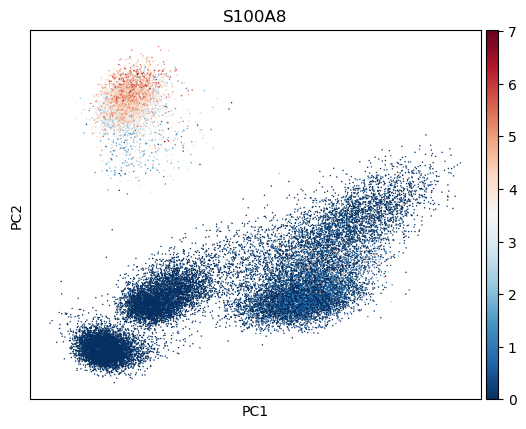

In [ ]:
sc.pl.pca(adata_non_immune_hvg,color="S100A8",cmap="RdBu_r")

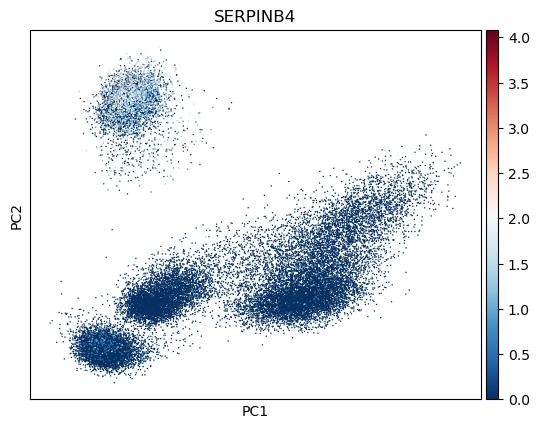

In [ ]:
sc.pl.pca(adata_non_immune_hvg,color="SERPINB4",cmap="RdBu_r")

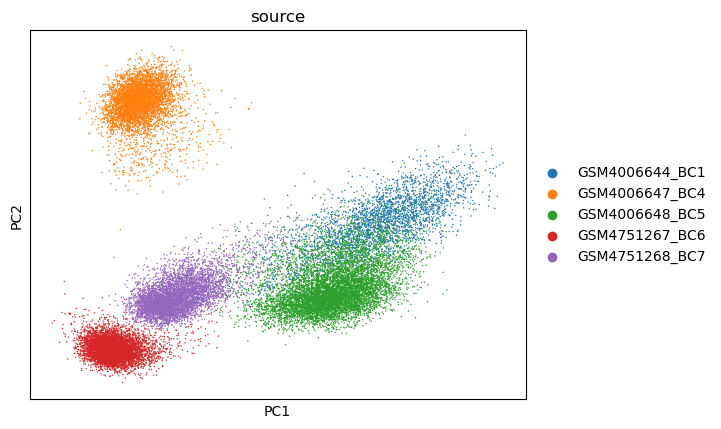

In [ ]:
sc.pl.pca(adata_non_immune_hvg,color="source",cmap="RdBu_r")

In [ ]:
wkdir= "/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_LINCS/"
data_year = "2020"
cell_name = "BC3C"

data_dir = os.path.join(wkdir,"00_outputs_" + data_year + "_" + cell_name)
data_file = os.path.join(data_dir, "Data_norm_" + data_year + "_" + cell_name+ ".xlsx")
Data_norm = pd.read_excel(data_file, index_col = 0)
display(Data_norm)

genes_list = Data_norm.columns.to_list()
print("Landmark genes in LINCS data:", len(genes_list), genes_list)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
ASG002_BC3C_24H:A03,-0.191254,-0.055246,0.039596,-0.256266,-0.040419,-0.590523,-0.159396,-0.074319,0.457981,0.409608,...,0.543203,0.494266,-0.011923,-0.225931,0.285054,-0.775246,0.166031,-0.024873,0.238723,0.284204
ASG002_BC3C_24H:A04,-0.265754,-0.317496,0.118696,-0.136665,-0.301569,-0.403023,0.124804,-0.036470,0.311931,0.660457,...,-0.565096,-0.088634,0.122977,-0.047931,0.141804,0.129054,-0.028819,-0.028773,-0.253627,-0.752646
ASG002_BC3C_24H:A05,-0.181954,-0.081597,-0.210304,1.559535,-0.019019,-0.457423,0.071404,0.074080,-0.356119,0.498808,...,0.226104,-0.228034,-0.121023,-0.075331,-0.133146,0.355054,0.022831,-0.084073,0.283123,-0.894896
ASG002_BC3C_24H:A06,0.033446,0.042404,-0.150154,-0.093165,0.053180,-0.053823,0.087704,0.167681,-0.601569,0.383308,...,-0.608596,-0.228835,0.072777,0.082970,-0.570996,2.847754,-0.211670,-0.067273,0.081723,0.338704
ASG002_BC3C_24H:J13,0.204446,0.180704,0.089096,-0.054666,0.053381,0.044877,-0.277396,-0.157419,0.535681,-3.933493,...,-0.318397,0.122265,-0.134323,-0.088931,-0.067996,-0.515847,-0.005069,0.067527,0.002223,0.204904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOAR012_BC3C_24H:P20,0.647151,0.211700,-0.979200,0.597350,-0.375751,0.388300,0.394524,0.120151,-0.166775,-1.129125,...,-1.598475,-0.552750,0.515151,0.120800,0.082675,0.529700,0.383225,-0.207225,2.268450,-1.248500
MOAR012_BC3C_24H:P21,0.171800,0.046300,-0.145550,-0.295150,0.030849,0.420951,0.222075,0.179800,0.274724,-0.423975,...,-1.650575,0.203600,-0.003250,-0.064800,-0.037675,0.076499,0.201825,0.416875,0.287450,-0.971700
MOAR012_BC3C_24H:P22,0.648700,0.058749,-0.031700,0.408249,-0.753950,0.332200,-0.357525,-0.107650,-0.213575,0.074225,...,0.127625,0.031600,0.103250,-0.249600,0.046375,1.486200,0.440325,0.090075,-0.031650,-0.944300
MOAR012_BC3C_24H:P23,0.090499,-0.469300,-0.611800,0.873550,-0.788450,-0.097199,-0.366575,-0.490600,-0.624675,-0.009275,...,0.054676,-0.596050,0.084600,0.444700,0.431375,-0.921501,0.044926,0.716076,-0.000900,-1.106700


Landmark genes in LINCS data: 978 ['AARS', 'ABCB6', 'ABCC5', 'ABCF1', 'ABCF3', 'ABHD4', 'ABHD6', 'ABL1', 'ACAA1', 'ACAT2', 'ACBD3', 'ACD', 'ACLY', 'ACOT9', 'ADAM10', 'ADAT1', 'ADGRE5', 'ADGRG1', 'ADH5', 'ADI1', 'ADO', 'ADRB2', 'AGL', 'AKAP8', 'AKAP8L', 'AKR7A2', 'AKT1', 'ALAS1', 'ALDH7A1', 'ALDOA', 'ALDOC', 'AMDHD2', 'ANKRD10', 'ANO10', 'ANXA7', 'APBB2', 'APOE', 'APP', 'APPBP2', 'ARFIP2', 'ARHGAP1', 'ARHGEF12', 'ARHGEF2', 'ARID4B', 'ARID5B', 'ARL4C', 'ARNT2', 'ARPP19', 'ASAH1', 'ASCC3', 'ATF1', 'ATF5', 'ATF6', 'ATG3', 'ATMIN', 'ATP11B', 'ATP1B1', 'ATP2C1', 'ATP6V0B', 'ATP6V1D', 'AURKA', 'AURKB', 'AXIN1', 'B4GAT1', 'BACE2', 'BAD', 'BAG3', 'BAMBI', 'BAX', 'BCL2', 'BCL7B', 'BDH1', 'BECN1', 'BHLHE40', 'BID', 'BIRC2', 'BIRC5', 'BLCAP', 'BLMH', 'BLVRA', 'BMP4', 'BNIP3', 'BNIP3L', 'BPHL', 'BRCA1', 'BTK', 'BUB1B', 'BZW2', 'C2CD2', 'C2CD2L', 'C2CD5', 'C5', 'CAB39', 'CALM3', 'CALU', 'CAMSAP2', 'CANT1', 'CAPN1', 'CARMIL1', 'CASC3', 'CASK', 'CASP10', 'CASP2', 'CASP3', 'CASP7', 'CAST', 'CAT', 'CBLB

In [ ]:
adata_non_immune.var.highly_variable.index

Index(['TSPAN6', 'GCLC', 'STPG1', 'CD99', 'HS3ST1', 'TMEM176A', 'CFLAR',
       'TFPI', 'ARF5', 'PLXND1',
       ...
       'CEP83-AS1', 'FO538757.2', 'AC090498.1', 'AC133644.2', 'LINC00921',
       'RP11-2C24.9', 'RP11-422P24.12', 'ADORA3', 'BISPR', 'RP11-297A16.4'],
      dtype='object', name='Gene', length=2500)

In [ ]:
genes_list = set(genes_list)
inters= genes_list.intersection(adata_non_immune.var.highly_variable.index)


In [ ]:
pd.Series(list(inters)).to_csv(
    '/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/gene_2500_lincs.csv',
    index=False,
    header=False
)

In [ ]:
pd.crosstab(adata_non_immune.obs['leiden'], adata_non_immune.obs['source'])

source,GSM4006644_BC1,GSM4006647_BC4,GSM4006648_BC5,GSM4751267_BC6,GSM4751268_BC7
leiden,,,,,
0,67,33,1344,1378,2551
1,214,3887,635,354,175
2,497,33,1464,2215,904
3,751,11,954,118,124
4,227,74,676,726,212
5,423,31,21,548,442
6,43,35,823,423,41
7,204,99,831,72,5
8,297,452,60,76,45


In [ ]:
loadings = adata_non_immune_hvg.varm['PCs']  # shape: (n_genes, n_pcs)

# Inspect top genes for PC1, for example
import pandas as pd
pc1 = pd.Series(loadings[:, 0], index=adata_non_immune_hvg.var_names)
top_pc1_genes = pc1.abs().sort_values(ascending=False).head(20)
print(top_pc1_genes)


Gene
CD24      0.082110
RPS18     0.079496
RPS27A    0.078895
RPL27A    0.078203
RPL13A    0.077935
RPS14     0.076175
FTH1      0.075877
RPL11     0.075015
RPL26     0.074569
KRT13     0.073889
CSTB      0.073740
TMEM97    0.072386
IFI27     0.071913
SYT8      0.071677
GSTM3     0.070976
BRI3      0.070448
FTL       0.070237
RPL35A    0.069390
RPL37A    0.069107
RPS4X     0.068964
dtype: float64


In [ ]:
pc1

Gene
TSPAN6            0.010245
GCLC              0.021930
STPG1             0.017705
CD99              0.037758
HS3ST1            0.023431
                    ...   
RP11-2C24.9       0.014370
RP11-422P24.12    0.005811
ADORA3            0.000395
BISPR             0.014265
RP11-297A16.4    -0.006475
Length: 2500, dtype: float64

In [ ]:
pc2 = pd.Series(loadings[:, 1], index=adata_non_immune_hvg.var_names)

top_pc2_genes = pc2.abs().sort_values(ascending=False).head(20)
print(top_pc2_genes)

Gene
MDM2        0.091925
S100A8      0.091344
DMKN        0.090886
S100A9      0.090851
CDC42SE1    0.090716
S100A14     0.088674
C1orf56     0.088655
CTNNB1      0.088428
SPINK1      0.087337
HNRNPH1     0.086466
EEF1A1      0.083177
RPS24       0.081884
MT1X        0.081853
RPLP0       0.081064
PPP1CB      0.079961
RPS6        0.079069
CDC42       0.078909
RIN2        0.077271
DEFB1       0.075935
PDLIM1      0.074768
dtype: float64


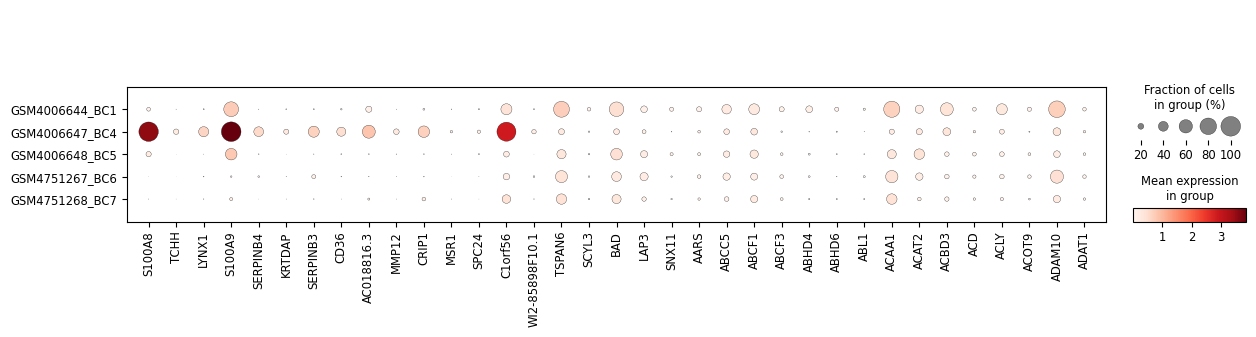

In [ ]:
sc.pl.dotplot(adata_non_immune, ["S100A8",
                                 "TCHH",
                                 "LYNX1","S100A9","SERPINB4","KRTDAP","SERPINB3","CD36","AC018816.3","MMP12","CRIP1","MSR1","SPC24","C1orf56","WI2-85898F10.1",
                                 'TSPAN6', 'SCYL3', 'BAD', 'LAP3', 'SNX11','AARS', 'ABCC5', 'ABCF1', 'ABCF3', 'ABHD4', 'ABHD6', 'ABL1', 'ACAA1', 'ACAT2', 'ACBD3', 'ACD', 'ACLY', 'ACOT9', 'ADAM10', 'ADAT1'],groupby='source')#8 umbrella cells

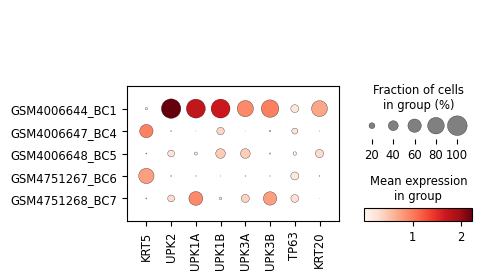

In [ ]:
sc.pl.dotplot(adata_non_immune, ['KRT5','UPK2','UPK1A','UPK1B','UPK3A','UPK3B','TP63','KRT20'],groupby='source')#8 umbrella cells